In [269]:
import os

import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

import numpy as np
import cv2
import matplotlib.pyplot as plt

from patchify import patchify
from PIL import Image

import json
import urllib

import xml.etree.ElementTree as ET
import shapely
import geopandas as gpd

## Load image and shapefile

In [13]:
raster_path = "data_raw\dop_kacheln\dop10rgbi_32_467_5763_1_nw_2020.jp2"

with rasterio.open(raster_path, "r") as src:
    raster_img = src.read()
    raster_meta = src.meta

In [15]:
shape_path = "data_raw\WFS_NW_ALKIS_Grundrissdaten_vereinfachtes_Schema\GebaeudeBauwerk.shp"
df = gpd.read_file(shape_path)

In [16]:
print(f"CRS Raster: {df.crs}, CRS vector: {src.crs}")

CRS Raster: epsg:25832, CRS vector: EPSG:25832


## Creates mask from shapefile and image

C:\Users\julia\AppData\Local\Temp\ipykernel_24880\889376520.py:4: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  poly = cascaded_union(polygon)


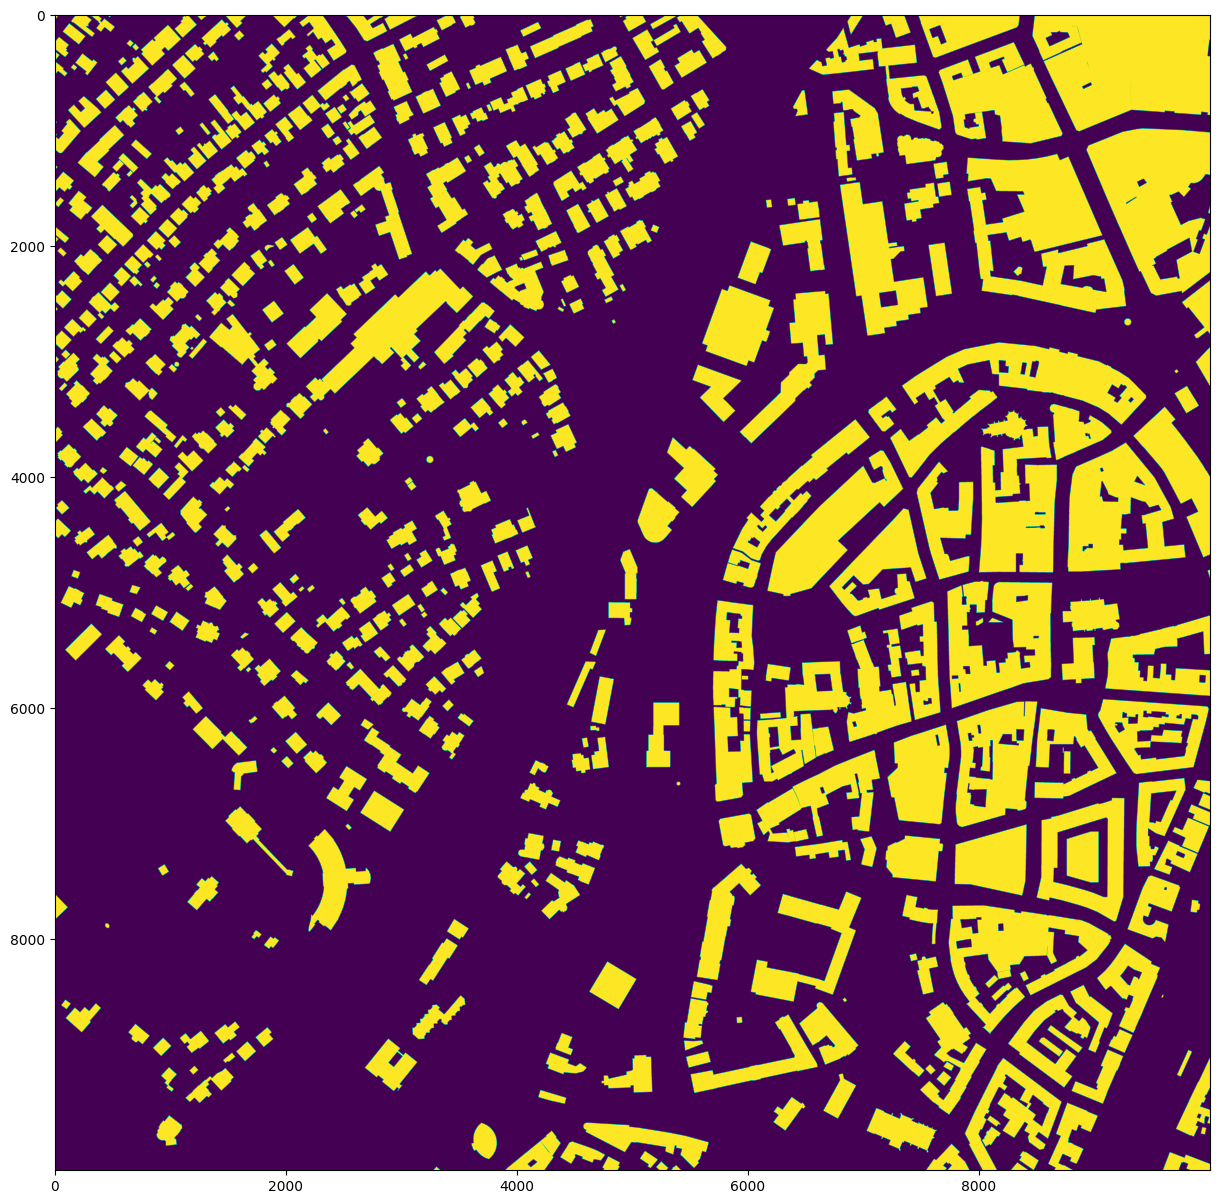

In [17]:
def poly_from_utm(polygon, transform):
    poly_pts = []
    
    poly = cascaded_union(polygon)
    for i in np.array(poly.exterior.coords):
        
        # Convert polygons to the image CRS
        poly_pts.append(~transform * tuple(i))
        
    # Generate a polygon object
    new_poly = Polygon(poly_pts)
    return new_poly

# Generate Binary maks

poly_shp = []
im_size = (src.meta['height'], src.meta['width'])
for num, row in df.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        poly = poly_from_utm(row['geometry'], src.meta['transform'])
        poly_shp.append(poly)
    else:
        for p in row['geometry']:
            poly = poly_from_utm(p, src.meta['transform'])
            poly_shp.append(poly)

mask = rasterize(shapes=poly_shp,
                 out_shape=im_size)

# Plot the mask

plt.figure(figsize=(15,15))
plt.imshow(mask)

In [18]:
mask = mask.astype("uint16")
save_path = "output/mask/test.tif"
bin_mask_meta = src.meta.copy()
bin_mask_meta.update({'count': 1})
with rasterio.open(save_path, 'w', **bin_mask_meta) as dst:
    dst.write(mask * 255, 1)

## Function to load and "patchify" images
* this works both for mask and images
* images should however be in tif format and since they have one channel more than the mask, the patchify call should be amended by something like **(3, patch_size, patch_size)**

In [101]:
def load_and_patchify(img_path, patch_size, output_path):
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    size_x = (img.shape[1]//patch_size) * patch_size
    size_y = (img.shape[0]//patch_size) * patch_size

    img = Image.fromarray(img)

    img = np.array(img.crop((0, 0, size_x, size_y)))

    patch_img = patchify(img, (patch_size, patch_size), step=patch_size) # somehow handle more than 3 channels here!
    
    for i in range(patch_img.shape[0]):
        for k in range(patch_img.shape[1]):
            single_patch_img = patch_img[i, k]
            
            path_string = str(i) + '_' + str(k) + '.png'
            
            file_path = os.path.join(output_path, path_string)
                
            cv2.imwrite(file_path, np.squeeze(single_patch_img))

In [102]:
load_and_patchify('output/mask/test.tif', 256, 'output/mask/masks')

c:\Users\julia\OneDrive\Documents\GitHub\building-segmentation-tutorial\seg_venv\Lib\site-packages\PIL\Image.py:3074: DecompressionBombWarning: Image size (99680256 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


## Get metadata of statellite imagery
(combined with the base url, we can just download the pictures from there. Shapefiles are much more difficult to extract...)

In [108]:
json_url = "https://www.opengeodata.nrw.de/produkte/geobasis/lusat/dop/dop_jp2_f10/index.json"

req = urllib.request.Request(json_url)
req.get_method = lambda: 'GET'
response = urllib.request.urlopen(req)


metadata = json.loads(response.read())

In [113]:
metadata_df = pd.DataFrame.from_records(metadata['datasets'][0]['files'])

In [116]:
metadata_df.sample(10)

,name,size,timestamp
7698,dop10rgbi_32_340_5754_1_nw_2022.jp2,70600354,2022-08-30T20:44:24
12031,dop10rgbi_32_364_5763_1_nw_2022.jp2,61115792,2022-08-31T05:26:33
4296,dop10rgbi_32_321_5636_1_nw_2021.jp2,42881842,2021-07-21T18:41:42
35520,dop10rgbi_32_520_5742_1_nw_2022.jp2,49608804,2022-11-10T21:16:35
18874,dop10rgbi_32_402_5666_1_nw_2021.jp2,47426086,2022-01-11T20:11:50
7435,dop10rgbi_32_339_5667_1_nw_2021.jp2,41325707,2021-07-15T09:57:17
16684,dop10rgbi_32_390_5662_1_nw_2021.jp2,48472329,2021-12-09T01:21:40
15383,dop10rgbi_32_383_5615_1_nw_2021.jp2,47183571,2021-09-16T05:40:45
2828,dop10rgbi_32_312_5720_1_nw_2020.jp2,42477793,2020-10-08T02:31:24
422,dop10rgbi_32_294_5676_1_nw_2020.jp2,43241565,2020-08-19T18:13:09


## WFS NRW
* ...what a pain
* function needs only the two bbox values from the Excel that comes along with the ortho-images download
* returns a geopandas dataframe with the strcuture id and the associated shapefile. 
* To-dos: iterate through the list of bbox values, then integrate with the process to generate masks from the shapefile-image combination

In [279]:
def get_shape_file(bbox2:tuple, crs='EPSG:25832') -> gpd.GeoDataFrame:
    
    BASE_URL = "https://www.wfs.nrw.de/geobasis/wfs_nw_alkis_vereinfacht?SERVICE=WFS&VERSION=2.0.0&REQUEST=GetFeature&TYPENAMES=ave:GebaeudeBauwerk&BBOX="
    
    x, y = bbox2
    x2 = x + 1000
    y2 = y + 1000
    
    bbox4 = (x, y, x2, y2)
    
    bbox_str = ','.join(list(map(str, bbox4)))
    
    gml_url = ''.join([BASE_URL, bbox_str])
    
    req = urllib.request.Request(gml_url)
    req.get_method = lambda: 'GET'
    response = urllib.request.urlopen(req)
    
    gml_str = response.read()
    
    root = ET.ElementTree(ET.fromstring(gml_str)).getroot()
    
    namespace = {'gml': "http://www.opengis.net/gml/3.2",
             'xlmns': "http://repository.gdi-de.org/schemas/adv/produkt/alkis-vereinfacht/2.0",
             'wfs': "http://www.opengis.net/wfs/2.0",
             'xsi': "http://www.w3.org/2001/XMLSchema-instance"
             }
    
    buildings = [geb.text for geb in root.findall('.//gml:posList', namespace)]
    
    ids = [i.items()[0][1] for i in root.findall('.//gml:MultiSurface[@gml:id]', namespace)]
    
    building_shapefiles = []
    
    for id, build in zip(ids, buildings):
        coord_iter = iter(build.split(' '))
        coords = list(map(tuple, zip(coord_iter, coord_iter)))
        
        poly = shapely.geometry.Polygon([[float(p[0]), float(p[1])] for p in coords])
        
        building_shapefiles.append({'id': id, 'geometry': poly})
    
    df = pd.DataFrame.from_records(building_shapefiles)
    gdf = gpd.GeoDataFrame(df, crs=crs)
    
    return gdf
    

In [280]:
test = get_shape_file((467000,5763000))